In [21]:
import numpy as np
import pandas as pd

from uszipcode import SearchEngine

In [22]:
pets = pd.read_csv('~/pets/Seattle_Pet_Licenses.csv', encoding='latin-1')

# shorten the names and remove punctuation & case for ease of coding
pets = pets.rename(columns={"License Issue Date": "issue_date", "License Number": "license_number", 
                            "Animal's Name": "animal_name", "Species": "species", "Primary Breed": "primary_breed",
                            "Secondary Breed": "secondary_breed", "ZIP Code": "zip",
                           })

pets.issue_date = pd.to_datetime(pets.issue_date)
pets['value'] = 1

In [23]:
# Clean the zip code data 
pets = pets[pets["zip"].notna()]

# remove last four digits of zip if they're there
def clean_zip(raw):
    if (len(raw) > 5):
        raw = raw.split('-')[0]
    return str(raw)

pets['cleaned_zip'] = pets['zip'].apply(clean_zip)

# remove some other random stuff I found
pets = pets[pets['cleaned_zip'].map(len) == 5]
pets = pets[pets.cleaned_zip != "98`78"]


pets.issue_date = pd.to_datetime(pets.issue_date)
pets['year'] = pets['issue_date'].apply(lambda x: x.isocalendar()[0])

In [24]:
# let's just use 2019 since it has the most adoptions
pets_short = pets[pets['year']==2019]

#make a pivot table of the number of animals in each zip
pets_pivot = pd.pivot_table(pets_short, values='value', index='cleaned_zip', columns='species', aggfunc=np.sum).reset_index()
pets_pivot=pets_pivot.fillna(0)

pets_pivot.head()

species,cleaned_zip,Cat,Dog,Goat,Pig
0,20650,2.0,0.0,0.0,0.0
1,21771,2.0,0.0,0.0,0.0
2,27601,1.0,0.0,0.0,0.0
3,52246,1.0,0.0,0.0,0.0
4,60134,1.0,0.0,0.0,0.0


In [25]:
# add some data using us zip code
search = SearchEngine(simple_zipcode=False)

def get_state(zip):
    result=search.by_zipcode(zip)
    return result.state

def get_pop(zip):
    result=search.by_zipcode(zip)
    return result.population

def get_income(zip):
    result=search.by_zipcode(zip)
    return result.median_household_income

pets_pivot['state'] = pets_pivot['cleaned_zip'].apply(lambda s: get_state(s))
pets_pivot['population'] = pets_pivot['cleaned_zip'].apply(lambda s: get_pop(s))
pets_pivot['median_income'] = pets_pivot['cleaned_zip'].apply(lambda s: get_income(s))

In [27]:
# Get rid of non-WA data
pets_pivot = pets_pivot[pets_pivot.state=="WA"]

In [28]:
# use uszipcode to find percentage of rentals in a given zip codde
def find_rentals(zip):
    #print(zip)
    zipcode = search.by_zipcode(zip)
    zipcode.to_dict()
    if zipcode.housing_occupancy != None:
        obj = zipcode.housing_occupancy[0]['values']
        mortgaged = obj[0]['y']
        owned = obj[1]['y']
        rented = obj[2]['y']
        vacant = obj[3]['y']
        total = mortgaged + owned + rented + vacant
        rentals = rented/total
    else:
        rentals = ''
    return rentals


# add percent rentals to the pivot table
pets_pivot['percent_rentals'] = pets_pivot['cleaned_zip'].apply(lambda s: find_rentals(s))

In [29]:
pets_pivot
pets_pivot=pets_pivot.fillna(0)

In [30]:
sum_columns = pets_pivot['Cat'] + pets_pivot['Dog']
pets_pivot["total_animals"] = sum_columns

count_dogs = pets_pivot['Dog']/pets_pivot['total_animals']
pets_pivot['percent_dogs'] = count_dogs

count_cats = pets_pivot['Cat']/pets_pivot['total_animals']
pets_pivot['percent_cats'] = count_cats

In [31]:
#export finished pivot table
pets_pivot.to_csv('pets_pivot.csv', index=False)

In [32]:
pets_pivot.head()

species,cleaned_zip,Cat,Dog,Goat,Pig,state,population,median_income,percent_rentals,total_animals,percent_dogs,percent_cats
12,98001,0.0,1.0,0.0,0.0,WA,31911.0,71746.0,0.210952,1.0,1.0,0.0
13,98003,2.0,0.0,0.0,0.0,WA,44151.0,45894.0,0.4757,2.0,0.0,1.0
14,98004,2.0,8.0,0.0,0.0,WA,27946.0,93521.0,0.402342,10.0,0.8,0.2
15,98005,0.0,2.0,0.0,0.0,WA,17714.0,84774.0,0.393804,2.0,1.0,0.0
16,98006,0.0,3.0,0.0,0.0,WA,36364.0,110290.0,0.189907,3.0,1.0,0.0


In [13]:
pets_pivot = pets_pivot[pets_pivot['percent_rentals'] != ""]

rentals = pets_pivot['percent_rentals'].astype(float)
cats = pets_pivot['percent_cats'].astype(float)

In [14]:
rentals.corr(cats)

0.011005109512279848

In [20]:
total_animals = pets_pivot['total_animals'].astype(float)
population = pets_pivot['population'].astype(float)

population.corr(total_animals)

0.09769196751094239

(array([ 8., 11., 14., 12., 16.,  9.,  6.,  8.,  2.,  2.]),
 array([0.08392156862745098, 0.15376829128746558, 0.22361501394748018,
        0.29346173660749475, 0.3633084592675094, 0.43315518192752395,
        0.5030019045875386, 0.5728486272475533, 0.6426953499075678,
        0.7125420725675824, 0.782388795227597], dtype=object),
 <a list of 10 Patch objects>)

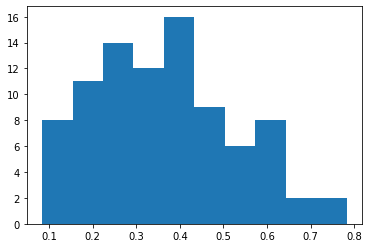

In [15]:
import matplotlib.pyplot as plt


plt.hist(pets_pivot['percent_rentals'], bins=10)

(array([27.,  0.,  3.,  7., 20.,  6.,  3.,  1.,  0., 21.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

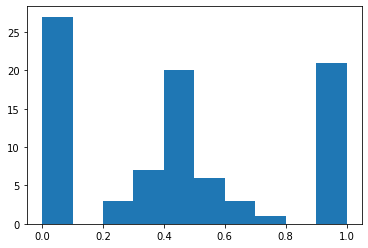

In [16]:
plt.hist(pets_pivot['percent_cats'], bins=10)

(array([21.,  0.,  1.,  3.,  4., 22.,  7.,  2.,  1., 27.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

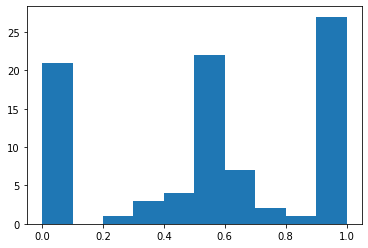

In [17]:
plt.hist(pets_pivot['percent_dogs'], bins=10)

In [ ]:
!pip install folium
import folium

In [ ]:
Seattle_map = folium.Map(location=[47.6062100,-122.3320700], tiles='Stamen Toner', zoom_start=9)